# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 2 sections:
- Vehicle Behaviour
- Reward Properties

With training progress analysis done, there is section to reoptimize action space according to selected top rewarded episodes. This allows to keep improving even a well trained model.

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
FS_June2020.npy			Spain_track.npy
H_track.npy			Straight_track.npy
LGSWide.npy			Tokyo_Training_track.npy
London_Loop_Train.npy		Vegas_track.npy
Mexico_track_eval.npy		Virtual_May19_Train_track.npy
Mexico_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("reInvent2019_track")

Loaded 155 waypoints


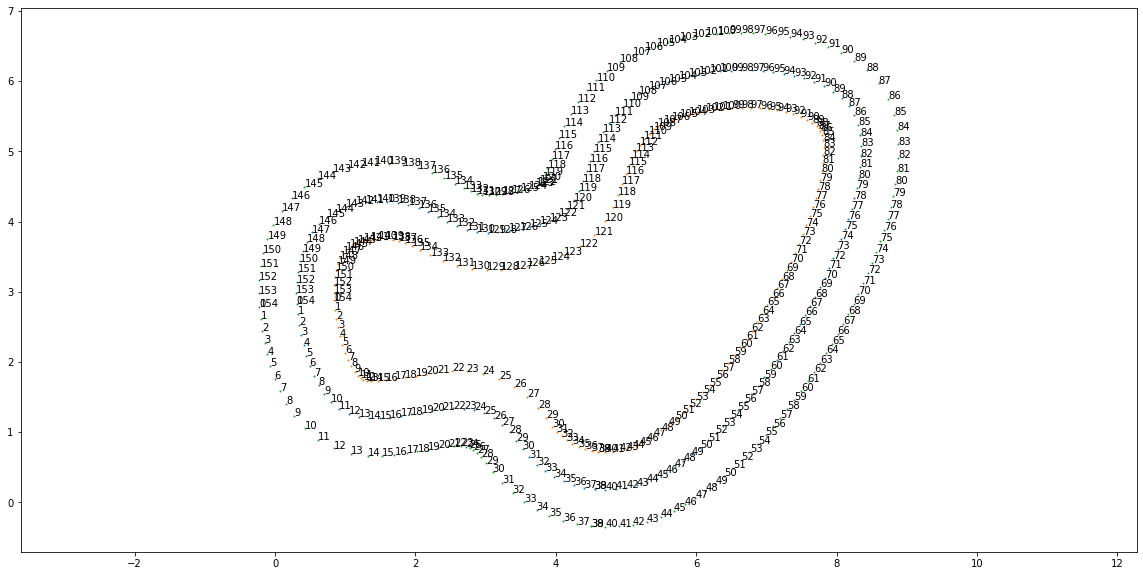

In [5]:
pu.plot_trackpoints(track)

In [6]:
def track_dheading(waypoints, N=2):
    """
    Calculate track waypoints heading in radians.
    N : waypoint look ahead
    """
    shifted = np.concatenate([waypoints[N:], waypoints[:N]])
    diff = shifted - waypoints
    t_heading = np.arctan2(diff.T[1], diff.T[0])
    dh = t_heading[1:] - t_heading[:-1]
    a = dh > math.pi
    b = dh < -math.pi
    dh[a] = dh[a] - 2*math.pi
    dh[b] = dh[b] + 2*math.pi
    return dh

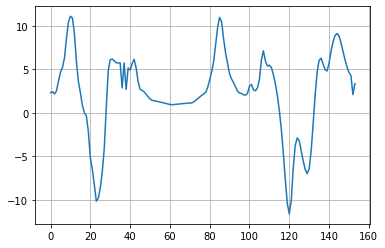

In [7]:
est_steering = np.degrees(track_dheading(track.center_line))
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

### Opposite direction
This code should be run to get estimated mean steering if trained with alternative direction parameter.

Such training runs agent in both directions changing heading every car reset.

In [8]:
inv_steering = np.array(list(reversed(est_steering)))
inv_steering *= -1
est_steering = (est_steering + inv_steering) / 2

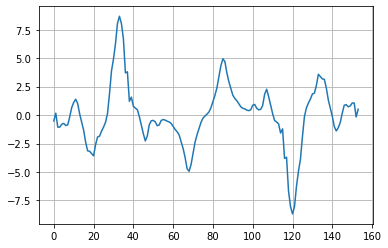

In [9]:
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

## Load log

In [89]:
stream_name = 'RIV-delta' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [94]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [95]:
EPISODES_PER_ITERATION = 30 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [96]:
df

iteration  episode  steps       x       y      yaw  steer  throttle  \
0              1        0      3  0.3277  2.6153 -84.8845   22.0       1.8   
1              1        0      4  0.3395  2.5079 -84.1185   22.0       1.8   
2              1        0      5  0.3427  2.4873 -83.7133   22.0       1.8   
3              1        0      6  0.3651  2.3792 -80.5648   10.0       2.7   
4              1        0      7  0.3878  2.2906 -78.1390   10.0       2.7   
...          ...      ...    ...     ...     ...      ...    ...       ...   
48092         30      899     15  0.6110  2.6521 -52.7836   10.0       2.7   
48093         30      899     16  0.7786  2.4303 -35.1813  -16.0       2.4   
48094         30      899     17  0.9174  2.2826 -24.4932    2.0       2.8   
48095         30      899     18  1.0467  2.1667 -18.4441  -16.0       2.4   
48096         30      899     19  1.1088  2.1172 -15.8659  -16.0       2.4   

       action  reward  done on_track  progress  closest_waypoint  track_len  \
0         6.0  1.4494     0     True    0.9345                 1      23.12   
1         6.0  2.6678     0     True    1.3998                 2      23.12   
2         6.0  1.9565     0     True    1.4902                 2      23.12   
3         4.0  1.8898     0     True    1.9660                 3      23.12   
4         4.0  2.5282     0     True    2.3614                 4      23.12   
...       ...     ...   ...      ...       ...               ...        ...   
48092     4.0  2.6783     0     True    5.9499                 1      23.12   
48093     0.0  2.7318     0     True    7.1521                 3      23.12   
48094     3.0  0.0123     0    False    7.9885                 5      23.12   
48095     0.0  0.0117     0    False    8.7540                 6      23.12   
48096     0.0  0.0138     1    False    9.2505                 7      23.12   

                timestamp  
0      1593427802.4158216  
1      1593427802.4620647  
2      1593427802.5578237  
3      1593427802.6485605  
4      1593427802.7325797  
...                   ...  
48092  1593435104.6159463  
48093  1593435104.7421541  
48094  1593435104.8554964  
48095  1593435104.9539304  
48096  1593435105.0252113  

[48097 rows x 16 columns]

# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [97]:
num_actions = int(df['action'].max() + 1)

0.0     7295
1.0     5650
2.0     4949
3.0     5052
4.0     5467
5.0     6770
6.0    12914
Name: action, dtype: int64

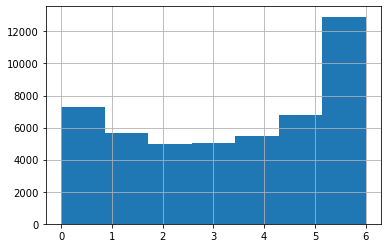

In [98]:
df['action'].hist(bins=num_actions)
df['action'].value_counts().sort_index()

(-16.0     7295
 -10.0     5650
 -4.0      4949
  2.0      5052
  10.0     5467
  16.0     6770
  22.0    12914
 Name: steer, dtype: int64,
 1.8    12914
 2.4    14065
 2.7    11117
 2.8    10001
 Name: throttle, dtype: int64)

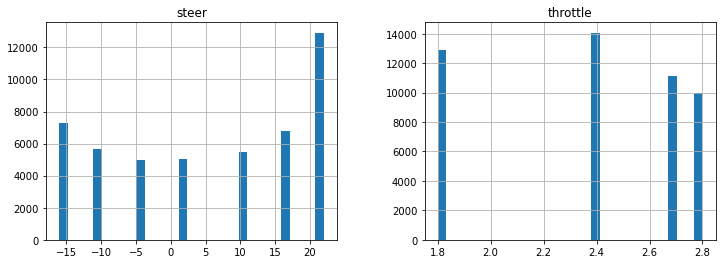

In [99]:
df[['steer', 'throttle']].hist(bins=31, figsize=(12,4))
df['steer'].value_counts().sort_index(), df['throttle'].value_counts().sort_index()

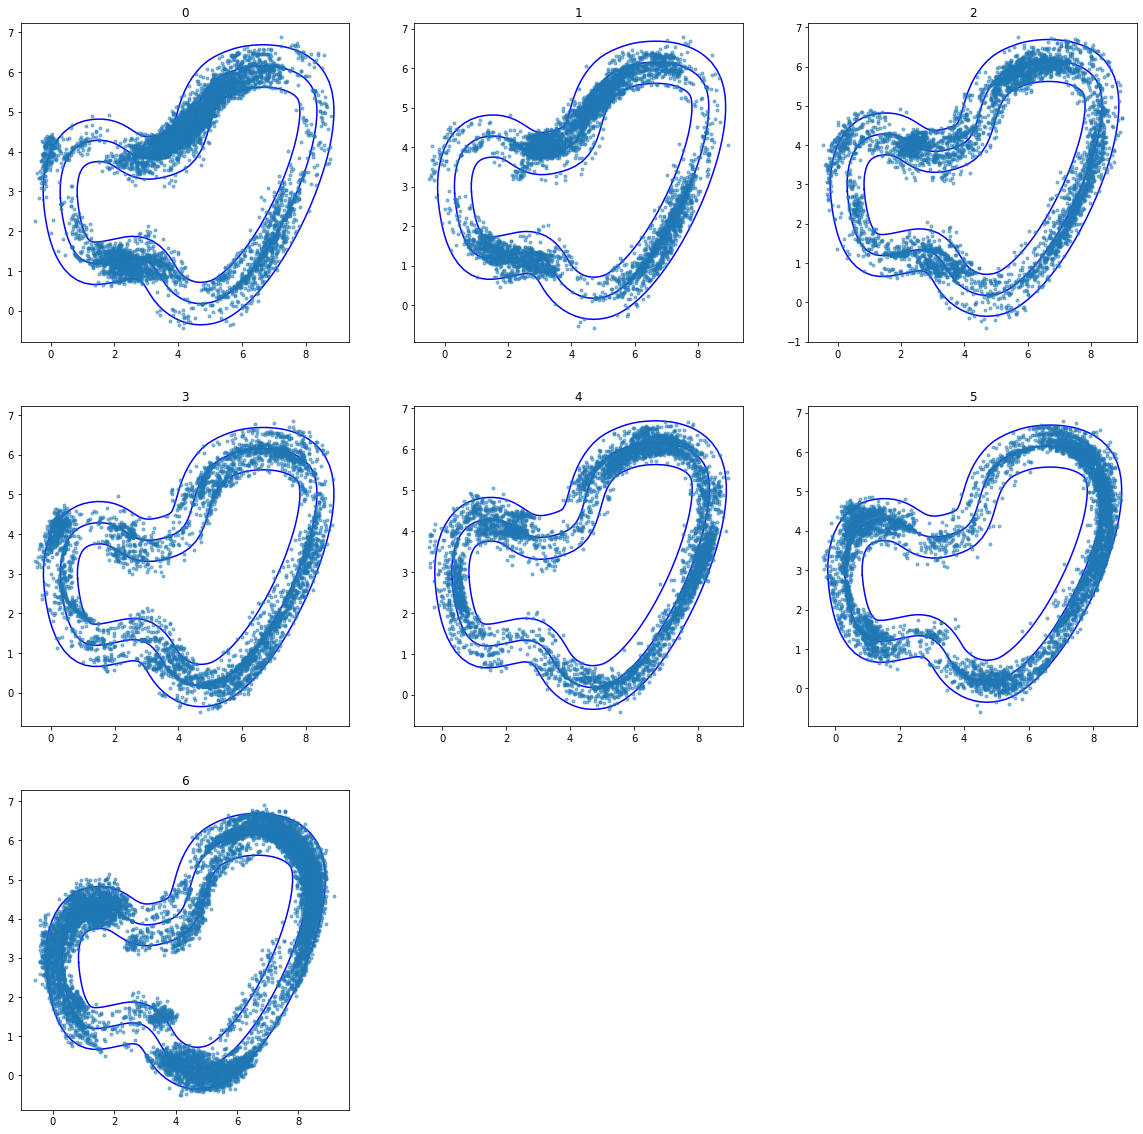

In [100]:
plt.figure(figsize=(20,20))
cols = 3
rows = num_actions // cols + 1
for i in range(0,num_actions):
    plt.subplot(rows, cols, i+1)
    plt.plot(*track.center_line.T, 'b')
    plt.plot(*track.outer_border.T, 'b')
    plt.plot(*track.inner_border.T, 'b')
    plt.plot(*df[df['action'] == i][['x','y']].values.T, '.', alpha=0.5)
    plt.title(i)

### Compare mean steering with estimate
Keep in mind that this is an estimatation of steering and not a perfect racing line solution. Your model should perform similarly to the estimated line but should be different from it as well if it correctly cuts corners or enters them.

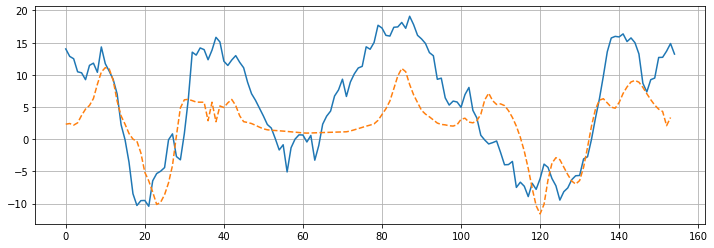

In [101]:
mean_steer = df[['steer', 'closest_waypoint']].groupby(by='closest_waypoint').mean()
plt.figure(figsize=(12,4))
plt.plot(mean_steer)
plt.plot(est_steering, '--')
plt.grid()

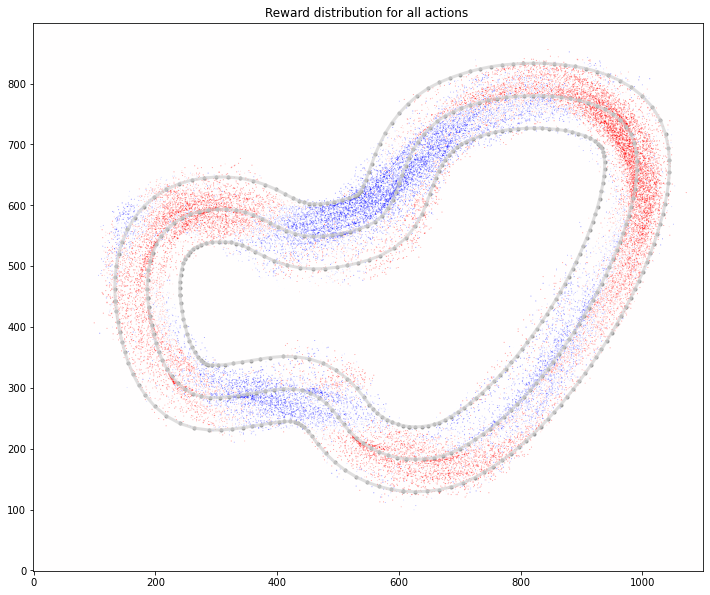

<Figure size 432x288 with 0 Axes>

In [102]:
CENTER_STEERING = 3.0
cpydf = df[['x','y','steer']].copy()
cpydf['steer'] = cpydf['steer'].values - CENTER_STEERING
pu.plot_track(cpydf, track, value_field='steer', margin=1, cmap='bwr')

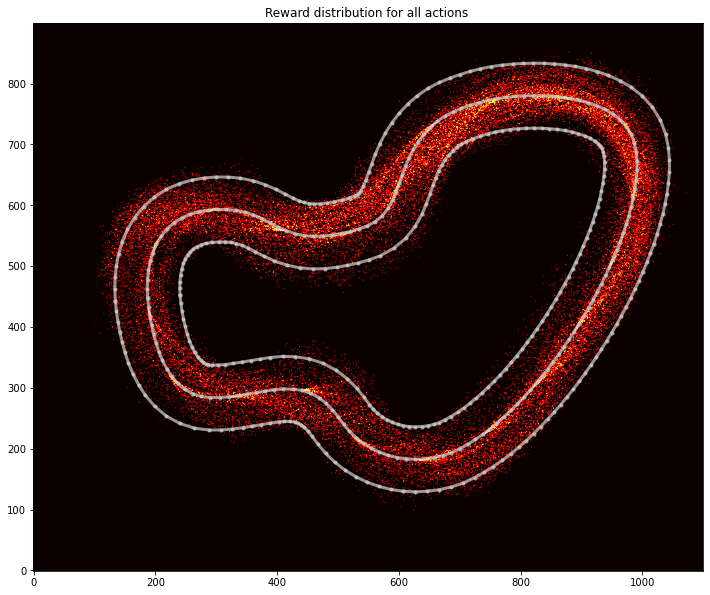

<Figure size 432x288 with 0 Axes>

In [103]:
pu.plot_track(df, track, value_field='throttle', margin=1)

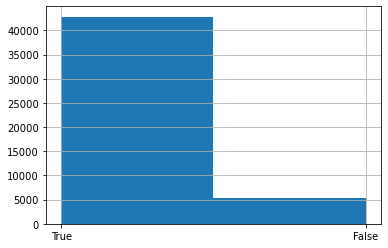

In [104]:
df['on_track'].hist(bins=2)

## Progress per steps
The higher the value the better.

In [105]:
pps = df['progress'].values / (1 + df['steps'].values)
df['pps'] = np.where(pps < 0.0, 0.0, pps)

In [106]:
sample = df[df['pps'] < 1.0]

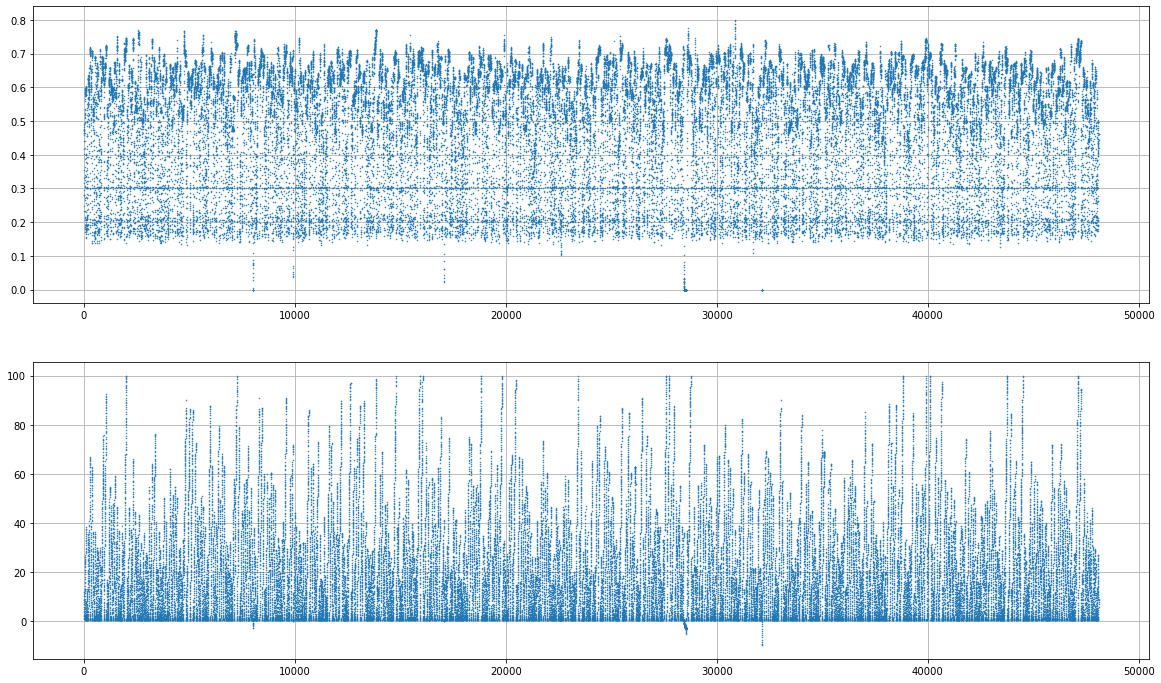

In [107]:
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.plot(np.arange(0,len(sample)), sample['pps'], '.', markersize=1)
plt.grid()
plt.subplot(212)
plt.plot(np.arange(0,len(sample)), sample['progress'], '.', markersize=1)
plt.grid()

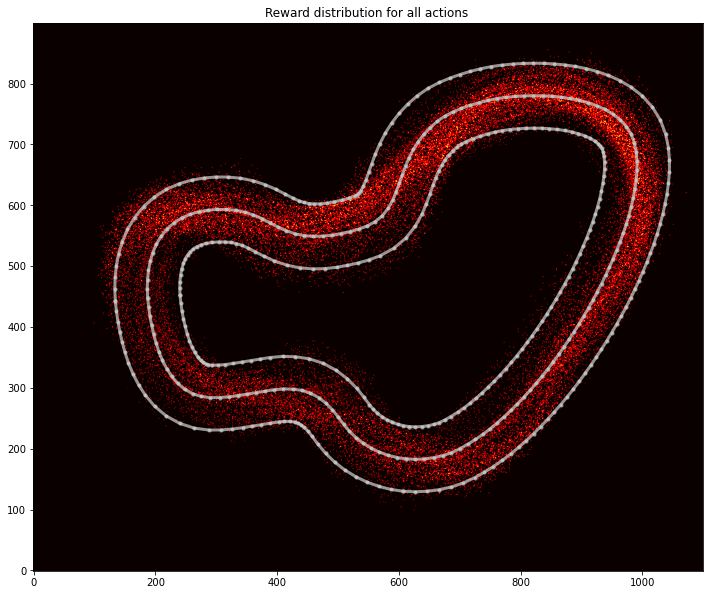

<Figure size 432x288 with 0 Axes>

In [108]:
pu.plot_track(sample, track, value_field='pps', margin=1)

In [109]:
df[['steps', 'progress']].corr()

steps  progress
steps     1.000000  0.984567
progress  0.984567  1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdfffe55b0>,
      dtype=object)

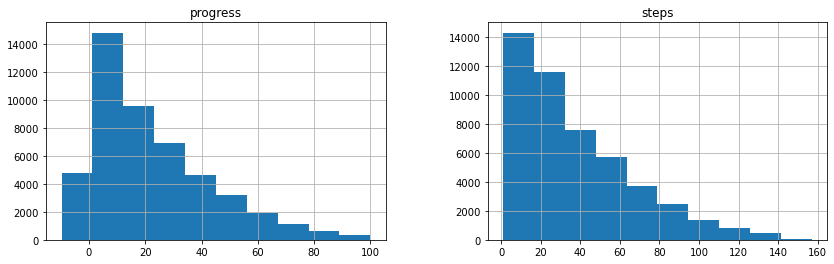

In [110]:
df[['steps', 'progress']].hist(figsize=(14,4))

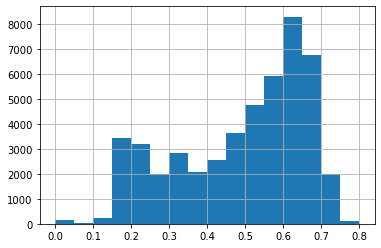

In [111]:
df['pps'].hist(bins=16)

## Progress and progress tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care only about distance covered towards the finish line.

The higher the value the better progress car is making.

In [112]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [113]:
TRACK_LEN = df['track_len'][0]

In [114]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + max(r['progress'],0.0) / 10.0) for _,r in df.iterrows()]

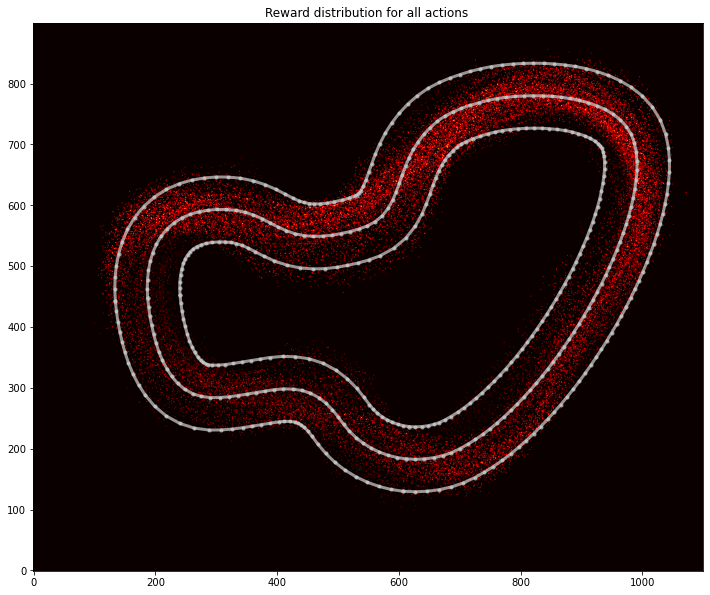

<Figure size 432x288 with 0 Axes>

In [115]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [116]:
df['tempo'] = tempo(df['progress']) * TRACK_LEN

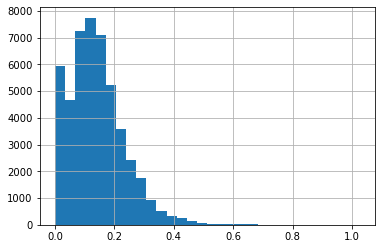

In [117]:
df['tempo'].hist(bins=30)

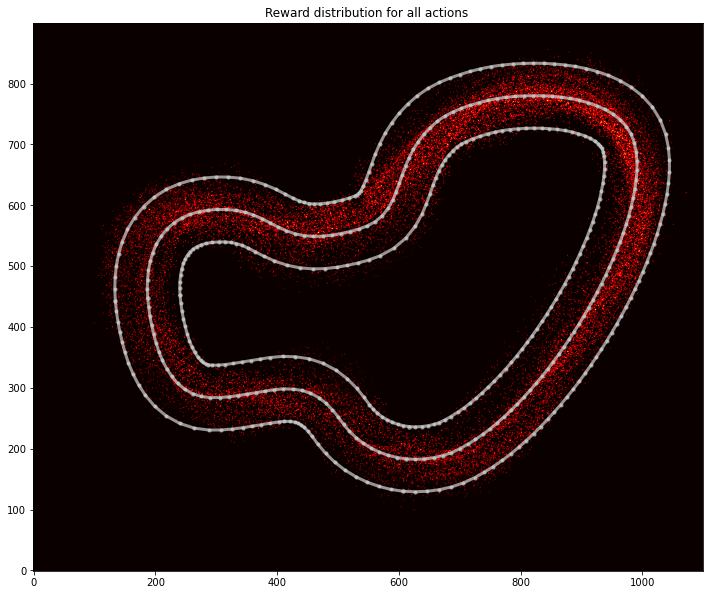

<Figure size 432x288 with 0 Axes>

In [118]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Training Metrics
Plot metrics with a console like plot.

> Keep in mind that there are no logs from evaluation runs, so you cannot see them here like you do inside AWS Console. Training episode progress is usually much worse because of the entropy that puts the car in unexcpected states.

In [119]:
metrics = df[['iteration','episode','reward','tempo']].copy()
metrics = metrics.groupby(by=['iteration','episode']).sum()
metrics.loc[:,'tempo'] = metrics.loc[:,'tempo'].values * 100 / TRACK_LEN
iter_metrics = metrics[['reward','tempo']].groupby(by='iteration').mean()

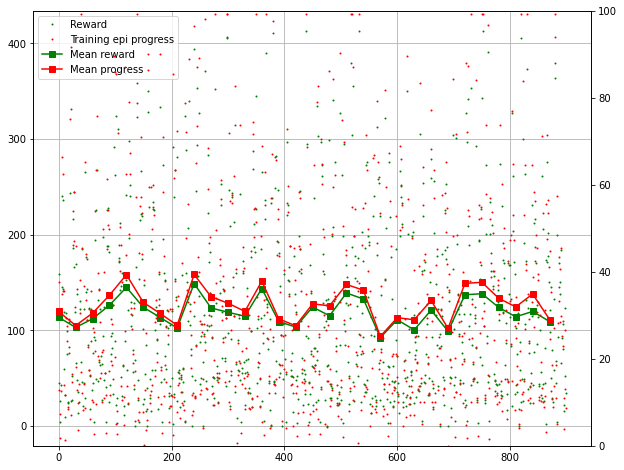

In [120]:
epi = np.arange(len(metrics))
it = np.arange(epi.min(), epi.max(), EPISODES_PER_ITERATION)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
axp = ax.twinx()
axp.set_ylim((0,100))
d1 = ax.plot(epi, metrics['reward'].values, 'g.', markersize=2)
d2 = axp.plot(epi, metrics['tempo'].values, 'r.', markersize=2)
d3 = ax.plot(it, iter_metrics['reward'].values, 'g-s')
d4 = axp.plot(it, iter_metrics['tempo'].values, 'r-s')
data = d1 + d2 + d3 + d4
ax.legend(data, ['Reward', 'Training epi progress', 'Mean reward', 'Mean progress'])
ax.grid()

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [121]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering_angle', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [122]:
import importlib

### Estimate missing parameters

In [123]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [124]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [125]:
name = 'adversarial'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [126]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [127]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe01921700>,
      dtype=object)

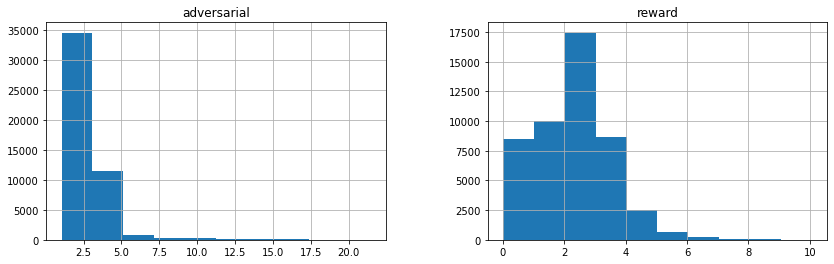

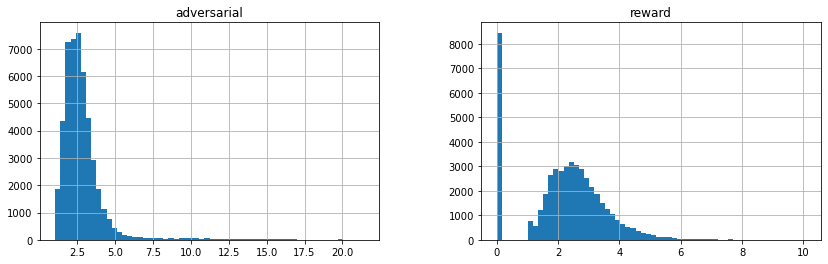

In [128]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [129]:
df[[original, name]].describe()

reward   adversarial
count  48097.000000  48097.000000
mean       2.233826      2.835394
std        1.355460      1.635609
min        0.001000      1.041991
25%        1.599300      1.990206
50%        2.337600      2.538743
75%        3.035600      3.180654
max       10.065500     21.419841

Text(0.5, 1.0, 'adversarial')

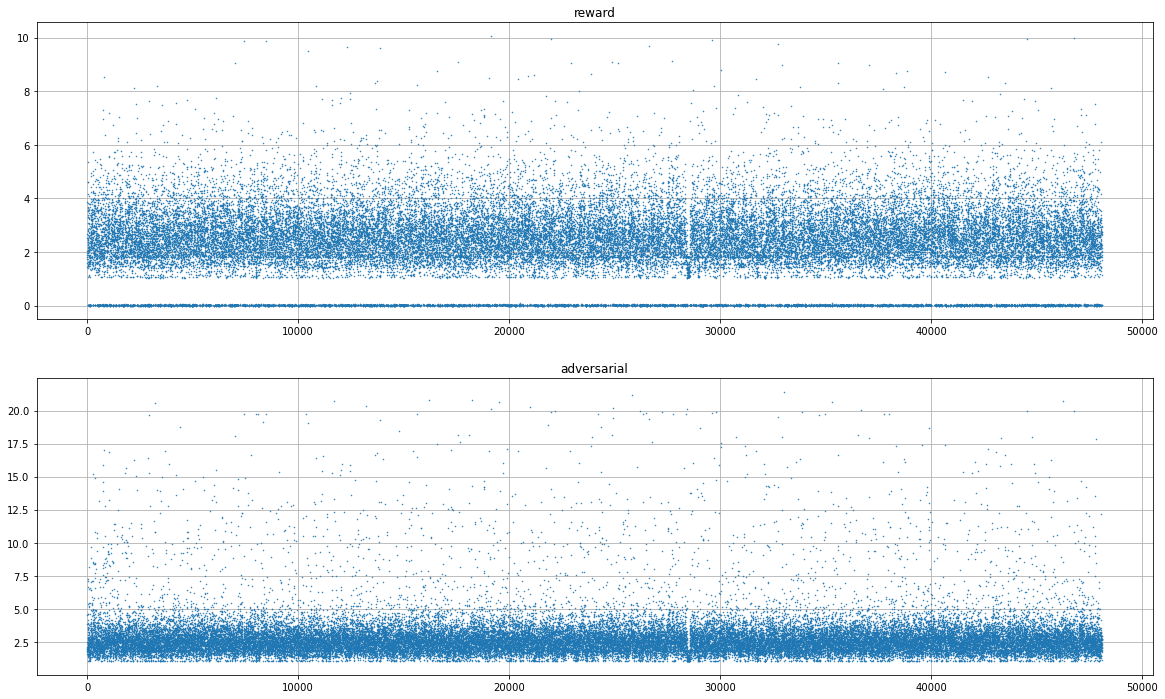

In [130]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.grid()
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.grid()
plt.title(name)

In [131]:
sample = df.sample(frac=0.75)
#sample = df[df[name] < 8]

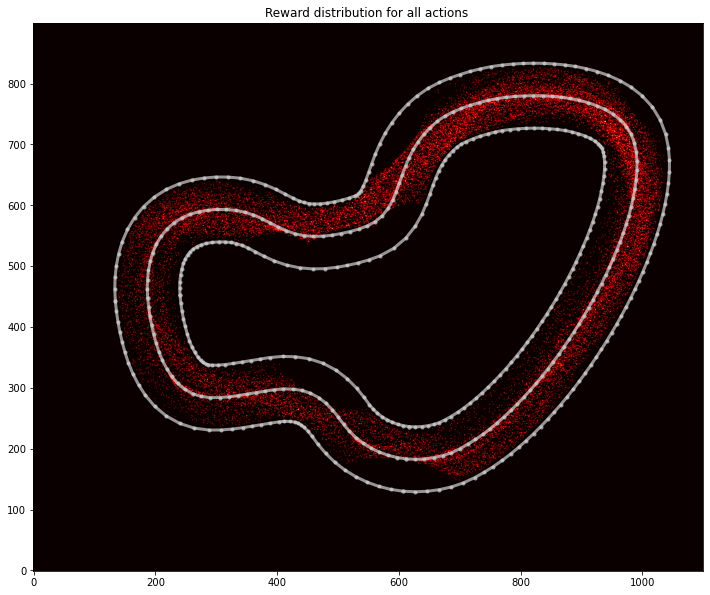

<Figure size 432x288 with 0 Axes>

In [132]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

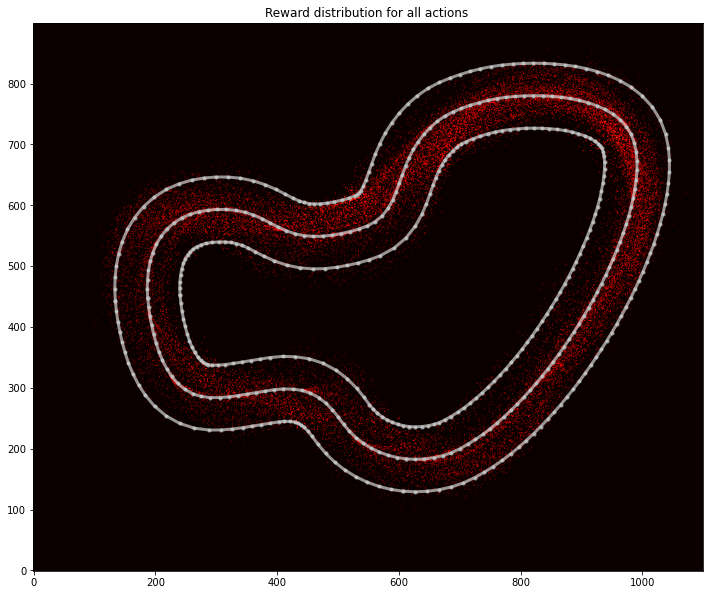

<Figure size 432x288 with 0 Axes>

In [133]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

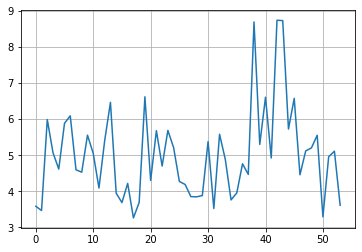

In [134]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])
plt.grid()

# Top explored solutions
Verify what your model has found to give the best results.

In [135]:
best_epi = df.groupby('episode').sum().nlargest(30, 'reward')
best_epi['steps'] = (np.sqrt(1 + best_epi['steps'].values * 8) - 1) / 2
best_epi['time'] = best_epi['steps'].values / 15

In [136]:
best_epi[['reward',name,'pps','tempo','distance_from_center', 'steps', 'time']].head()

reward  adversarial        pps      tempo  distance_from_center  \
episode                                                                      
438      413.2573   475.031256  77.825929  22.980355             25.234670   
533      412.9072   483.751754  96.921551  22.980078             30.567575   
752      412.6413   428.913007  91.538565  22.980170             27.470037   
380      410.5970   446.970636  85.281089  22.584703             30.285189   
299      406.7249   448.534687  87.470055  22.979569             24.210647   

         steps      time  
episode                   
438      146.0  9.733333  
533      149.0  9.933333  
752      145.0  9.666667  
380      146.0  9.733333  
299      140.0  9.333333

In [137]:
best_epi[['reward',name,'pps','tempo','distance_from_center', 'steps', 'time']].tail()

reward  adversarial        pps      tempo  distance_from_center  \
episode                                                                      
750      342.4619   480.322853  84.687265  22.980055             31.758182   
726      341.8485   410.501813  78.837799  20.202903             22.966547   
486      341.1049   394.147276  73.031152  19.488264             27.421638   
231      339.9660   429.183084  80.020049  20.581008             39.846088   
458      334.3219   369.442907  67.987615  18.285654             20.571828   

         steps      time  
episode                   
750      133.0  8.866667  
726      132.0  8.800000  
486      125.0  8.333333  
231      140.0  9.333333  
458      116.0  7.733333

In [138]:
best_epi[['reward',name,'pps','tempo','distance_from_center', 'steps', 'time']].describe()

reward  adversarial        pps      tempo  distance_from_center  \
count   30.000000    30.000000  30.000000  30.000000             30.000000   
mean   372.673113   438.650428  83.971568  21.997160             28.762732   
std     26.145404    29.187245   6.907402   1.379732              5.732662   
min    334.321900   369.442907  67.987615  18.285654             20.571828   
25%    350.637925   414.077730  78.909678  20.753431             24.299756   
50%    370.498600   443.028919  85.525161  22.979569             28.430818   
75%    393.211525   457.277323  88.680392  22.980072             31.272071   
max    413.257300   483.751754  96.921551  22.980540             40.968114   

            steps       time  
count   30.000000  30.000000  
mean   138.200000   9.213333  
std      8.766708   0.584447  
min    116.000000   7.733333  
25%    132.250000   8.816667  
50%    138.000000   9.200000  
75%    145.000000   9.666667  
max    157.000000  10.466667

In [139]:
best_epi_index = np.vectorize(lambda x: x in best_epi.index.values)(df['episode'].values)
best_epi = df[best_epi_index]

In [140]:
best_waypoint = best_epi.groupby('closest_waypoint').mean()

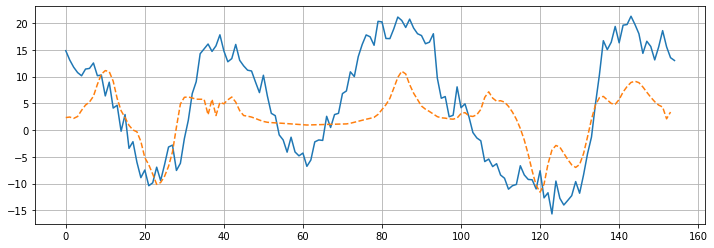

In [141]:
mean_steer = best_waypoint['steer']
plt.figure(figsize=(12,4))
plt.plot(mean_steer)
plt.plot(est_steering, '--')
plt.grid()

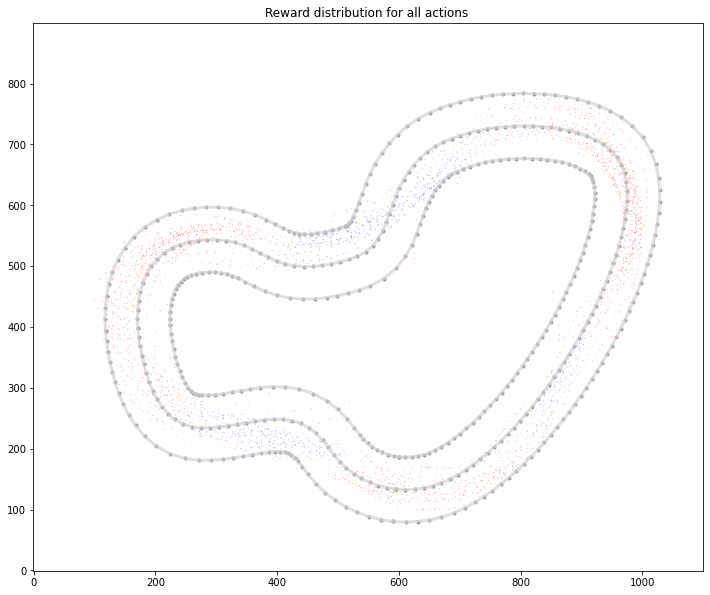

<Figure size 432x288 with 0 Axes>

In [142]:
cpydf = best_epi[['x','y','steer']].copy()
cpydf['steer'] = cpydf['steer'].values - CENTER_STEERING
pu.plot_track(cpydf, track, value_field='steer', margin=1, cmap='bwr')

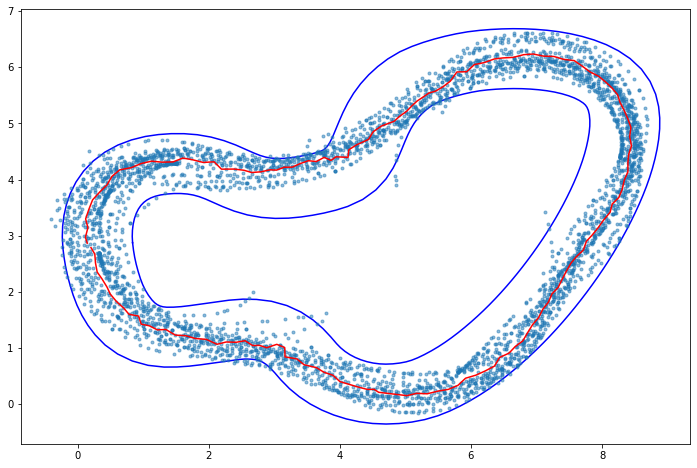

In [143]:
plt.figure(figsize=(12,8))
plt.plot(*track.outer_border.T, 'b')
plt.plot(*track.inner_border.T, 'b')
plt.plot(best_epi['x'].values, best_epi['y'].values, '.', alpha=0.5)
plt.plot(best_waypoint['x'].values, best_waypoint['y'].values, 'r-')

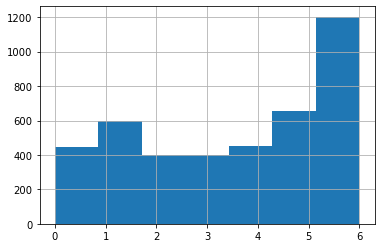

In [144]:
best_epi['action'].hist(bins=int(df['action'].max() + 1))

(-16.0     447
 -10.0     595
 -4.0      398
  2.0      400
  10.0     450
  16.0     653
  22.0    1203
 Name: steer, dtype: int64,
 1.8    1203
 2.4    1100
 2.7    1045
 2.8     798
 Name: throttle, dtype: int64)

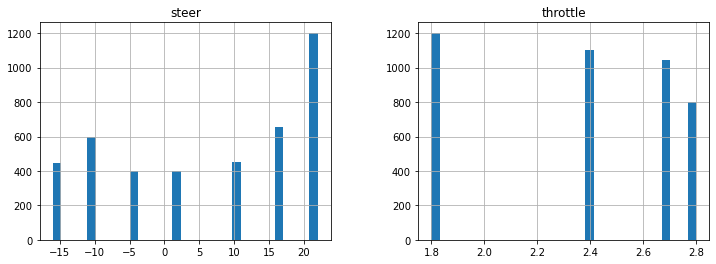

In [145]:
best_epi[['steer','throttle']].hist(bins=31, figsize=(12,4))
best_epi['steer'].value_counts().sort_index(), best_epi['throttle'].value_counts().sort_index()

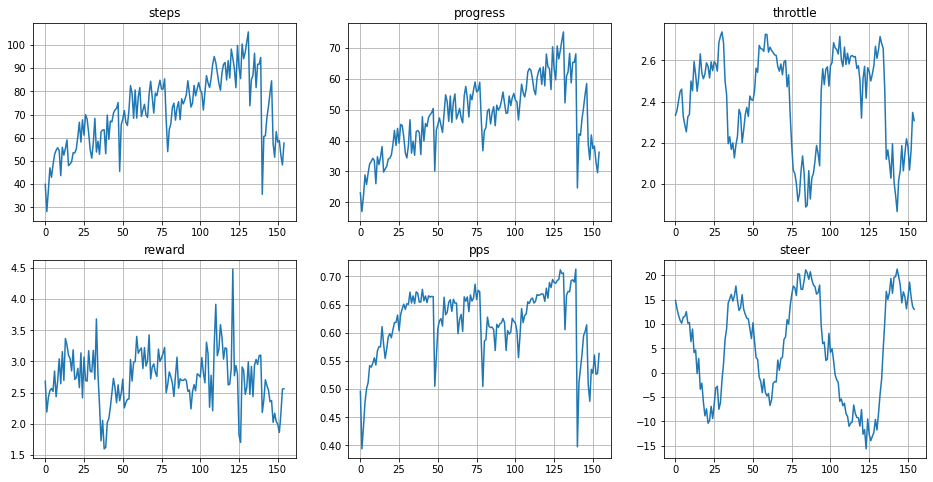

In [146]:
subplots = [(231,'steps'), (232,'progress'), (235,'pps'), (233,'throttle'), (236,'steer'), (234,'reward')]
plt.figure(figsize=(16,8))
for s in subplots:
    plt.subplot(s[0])
    plt.plot(best_waypoint[s[1]])
    plt.title(s[1])
    plt.grid()

## Reoptimize action space
Try to replace current actions with a better solution. Uses k-means clustering to solve this problem.

In [147]:
from sklearn.cluster import KMeans

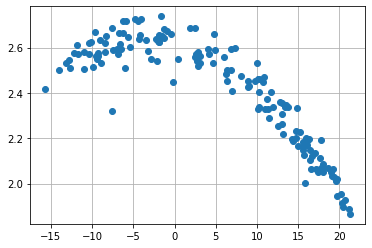

In [148]:
actions = best_waypoint[['steer','throttle']].values
plt.plot(*actions.T, 'o')
plt.grid()

In [63]:
N_OF_ACTIONS = 7
km = KMeans(n_clusters=N_OF_ACTIONS).fit(actions)
centers = km.cluster_centers_

In [64]:
new_actions = pd.DataFrame(centers, columns=['steer','throttle']).sort_values(['steer','throttle']).reset_index(drop=True)

### Interpolate
Before plotting the results it is convenient to match them with known limits.
KMeans discards maximum and minimum values which are crucial to finish a lap.

Below one can read min and max actions that should allow to finish a lap, but it is up to user which range you want to use - possibly higher speeds.

In [65]:
def max_speed(steering, vmax=1.4, smax=30.0):
    st = np.abs(np.where(steering == 0.0, 1e-2, steering))
    v = vmax * np.sin(np.radians(smax)) / np.sin(np.radians(st))
    return np.array([steering, np.where(v > 4.0, 4.0, v)])

In [66]:
# first row = throttle | second row = steering
limits = np.array([actions.min(axis=0), actions.max(axis=0)]).T
limits

array([[-14.90909091,  20.8       ],
       [  1.92      ,   2.54814815]])

In [67]:
th = new_actions['throttle'].values
new_actions['ithrottle'] = np.interp(th, (th.min(), th.max()), (1.8, 3.0))

In [68]:
st = new_actions['steer'].values
new_actions['isteer'] = np.interp(st, (st.min(), st.max()), (-15.0, 21.0))

### Optimizied action space

In [69]:
new_actions[['throttle','ithrottle','steer','isteer']]

throttle  ithrottle      steer     isteer
0  2.445475   2.869182 -11.697829 -15.000000
1  2.498188   3.000000  -5.433491  -7.541684
2  2.486304   2.970506  -0.410973  -1.561878
3  2.416413   2.797060   4.951245   4.822374
4  2.339125   2.605258   9.685213  10.458632
5  2.155333   2.149145  15.292556  17.134730
6  2.014643   1.800000  18.539048  21.000000

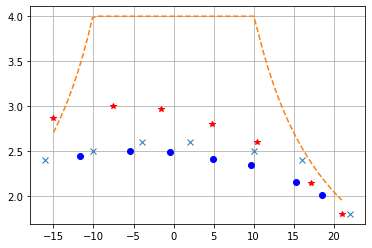

In [70]:
plt.plot(*new_actions[['steer','throttle']].values.T, 'bo')
plt.plot(*new_actions[['isteer','ithrottle']].values.T, 'r*')
plt.plot(*np.unique(best_epi[['steer','throttle']].values, axis=0).T, 'x')
plt.plot(*max_speed(np.linspace(new_actions.min()['isteer'], new_actions.max()['isteer'], num=60)), '--')
plt.grid()

# Bonus: Analyze reward distribution

Here we create heatmaps with reward distribution along 2 parameters of choice.

In [131]:
def plot3d_reward(x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library,
    # which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    sns.heatmap(Z)

In [132]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [133]:
src = df.sample(n=1)
src

iteration  episode  steps       x       y       yaw  steer  throttle  \
27640         14      416     15  2.3932  4.1407  155.7938   11.0       2.5   

       action  reward  ...  progress closest_waypoint  track_len  \
27640     4.0  3.7333  ...    6.7768              134      23.12   

                timestamp      pps log_progress     tempo  \
27640  1592911834.6350677  0.42355     0.517412  1.764336   

       distance_from_center  log_reward  log_tempo  
27640              0.107024    1.554623   1.016801  

[1 rows x 22 columns]

In [134]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [135]:
X = np.linspace(0.0, params['track_width'], num=100)
Y = np.linspace(-180, 180, num=100)

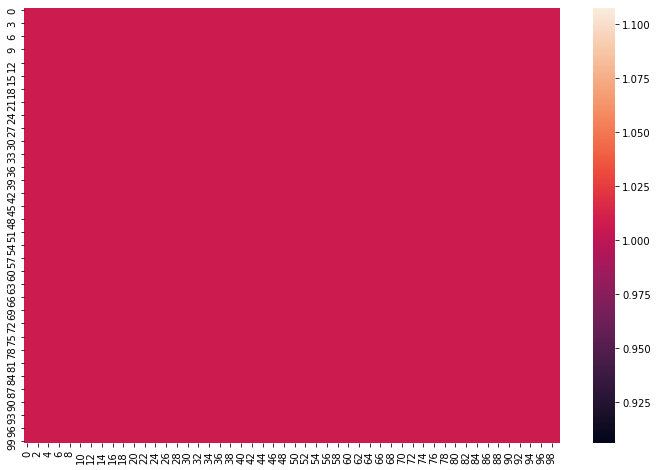

In [136]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(X, Y, rew)

## Helper: Compare functions
Choose your warrior wisely. Your function needs improvement? Incorrect distribution? Don't worry! Let's see which function does suit your needs best!

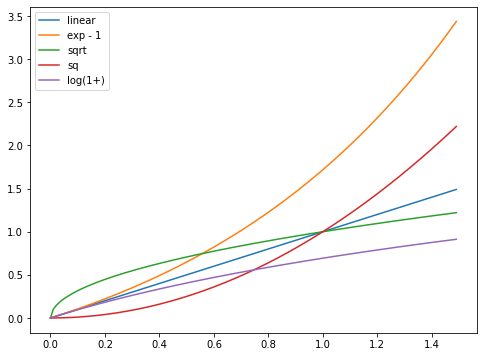

In [74]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])